In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
def select_column(column_name: str, success: bool) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/new.db')

    # Query to extract relevant records
    query = f"""
    SELECT workflow, failure_type, {column_name}, resilience 
    FROM workflow 
    WHERE {column_name} IS NOT NULL
    AND failure_rate_set IS 0.1
    AND node_cnt IS 32;
    """

    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)
    df = df.sort_values(by=['failure_type', 'workflow'])

    # Close the database connection
    conn.close()

    return df


In [3]:
def draw_df(column_name: str, df: pd.DataFrame):
    # Calculate normalized makespan
    def calculate_normalized_makespan(group):
        avg_makespan_1 = group[group['resilience'] == 1][column_name].mean()
        avg_makespan_0 = group[group['resilience'] == 0][column_name].mean()
        return avg_makespan_1 / avg_makespan_0
    
    sns.set_palette("pastel")
    
    # Filter out 'manager-killed' failure type
    df = df[df['failure_type'] != 'manager-killed']
    df = df[df['workflow'] != 'montage']

    normalized_df = df.groupby(['failure_type', 'workflow']).apply(calculate_normalized_makespan).reset_index()
    normalized_df.columns = ['failure_type', 'workflow', f'normalized_{column_name}']

    # Set up the plot
    plt.figure(figsize=(12, 4))
    sns.set_style("whitegrid")

    # Create the grouped bar plot
    ax = sns.barplot(x='failure_type', y=f'normalized_{column_name}', hue='workflow', data=normalized_df)

    # Add a horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--')

    # Customize the plot
    # plt.title(f'Normalized {column_name} of Resilience Module by Failure Type and Workflow', fontsize=16)
    plt.xlabel('Failure Type', fontsize=12)
    plt.ylabel(f'Normalized {column_name}', fontsize=12)
    plt.legend(title='Workflow', title_fontsize='12', fontsize='10')

    # Add value labels on top of each bar
    # for container in ax.containers:
    #     ax.bar_label(container, fmt='%.2f', padding=3)

    # Adjust layout and display the plot
    plt.tight_layout()
    # plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/normalized_{column_name}.pdf')
    plt.show()


In [3]:
def draw_df(column_name: str, df: pd.DataFrame):
    # Calculate normalized makespan and stderr
    def calculate_normalized_makespan(group):
        avg_makespan_1 = group[group['resilience'] == 1][column_name].mean()
        avg_makespan_0 = group[group['resilience'] == 0][column_name].mean()
        stderr_makespan_1 = group[group['resilience'] == 1][column_name].sem()
        stderr_makespan_0 = group[group['resilience'] == 0][column_name].sem()
        normalized_mean = avg_makespan_1 / avg_makespan_0
        normalized_stderr = normalized_mean * ((stderr_makespan_1 / avg_makespan_1) ** 2 + (stderr_makespan_0 / avg_makespan_0) ** 2) ** 0.5
        return pd.Series([normalized_mean, normalized_stderr], index=[f'normalized_{column_name}', f'normalized_{column_name}_stderr'])
    
    sns.set_palette("pastel")
    
    # Filter out 'manager-killed' failure type and 'montage' workflow
    df = df[df['failure_type'] != 'manager-killed']
    df = df[df['workflow'] != 'montage']

    normalized_df = df.groupby(['failure_type', 'workflow']).apply(calculate_normalized_makespan).reset_index()

    # Set up the plot
    plt.figure(figsize=(12, 3))
    sns.set_style("whitegrid")

    plt.rc('font', size=12)  # 控制默认文本的大小
    plt.rc('axes', titlesize=12)  # 控制标题的大小
    plt.rc('axes', labelsize=12)  # 控制x轴和y轴标签的大小
    plt.rc('xtick', labelsize=12)  # 控制x轴刻度的大小
    plt.rc('ytick', labelsize=12)  # 控制y轴刻度的大小
    plt.rc('legend', fontsize=12)  # 控制图例的字体大小

    # Create the grouped bar plot with error bars
    ax = sns.barplot(x='failure_type', y=f'normalized_{column_name}', hue='workflow', data=normalized_df, ci=None)

    # Add error bars manually
    unique_workflows = normalized_df['workflow'].unique()
    unique_failure_types = normalized_df['failure_type'].unique()
    for i, bar in enumerate(ax.patches):
        # Calculate the index for the normalized_df
        workflow_index = i // len(unique_failure_types)
        failure_type_index = i % len(unique_failure_types)
        if workflow_index < len(unique_workflows) and failure_type_index < len(unique_failure_types):
            row = normalized_df[(normalized_df['workflow'] == unique_workflows[workflow_index]) & 
                                (normalized_df['failure_type'] == unique_failure_types[failure_type_index])]
            if not row.empty:
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                yerr = row[f'normalized_{column_name}_stderr'].values[0]
                plt.errorbar(x=x, y=y, yerr=yerr, fmt='none', c='black', capsize=3)

    # Add a horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--')

    # Customize the plot
    plt.xlabel('Failure Type', fontsize=12)
    plt.ylabel(f'Normalized time to failure', fontsize=12)
    ax.set_ylim(0, 2)

    # 获取当前图例
    handles, labels = plt.gca().get_legend_handles_labels()

    # 将每个图例项的标签首字母大写
    new_labels = []
    for label in labels:
        if label == 'ulimit':
            new_labels.append('ulimit')
        else:
            new_labels.append(label.capitalize())

    # 绘制图例并设置新的标签
    plt.legend(handles, new_labels, title_fontsize='12', fontsize='10', loc='upper right', ncol=2)
    # plt.legend(title='Workflow', title_fontsize='12', fontsize='10')

    # 获取当前 x 轴标签并将其首字母大写
    labels = ax.get_xticklabels()
    new_labels = []
    for label in labels:
        if label.get_text() == 'ulimit':
            new_labels.append('ulimit')
        else:
            new_labels.append(label.get_text().capitalize())
    ax.set_xticklabels(new_labels)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/normalized_{column_name}.pdf')
    plt.show()


In [4]:
def draw_column(column_name: str, success: bool):
    df = select_column(column_name, success)
    draw_df(column_name, df)

/tmp/ipykernel_20794/550785361.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = df.groupby(['failure_type', 'workflow']).apply(calculate_normalized_makespan).reset_index()
/tmp/ipykernel_20794/550785361.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='failure_type', y=f'normalized_{column_name}', hue='workflow', data=normalized_df, ci=None)
/tmp/ipykernel_20794/550785361.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


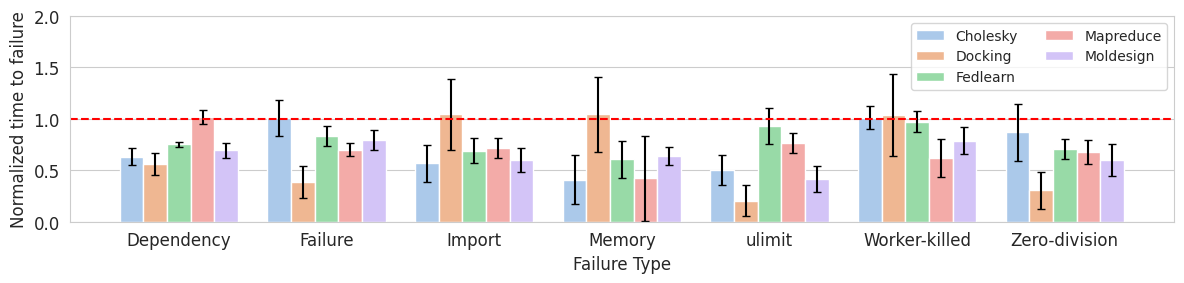

In [5]:
draw_column('makespan', False)

In [ ]:
draw_column('makespan')

In [ ]:
draw_column('average_task_time')
draw_column('task_success_rate')
draw_column('retry_success_rate')

In [ ]:
draw_column('average_task_time')
draw_column('task_success_rate')
draw_column('retry_success_rate')

In [14]:
conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/new.db')

# Query to extract relevant records
query = f"""
SELECT workflow, failure_type, overhead, makespan, task_count, overhead/makespan*100 AS percentage, overhead/task_count AS overhead_per_task, resilience 
FROM workflow 
WHERE overhead IS NOT NULL
AND makespan IS NOT NULL
AND failure_rate_set IS 0.1
AND node_cnt IS 32;
"""

# Load data into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()


df = df[df['failure_type'] != 'manager-killed']
df = df[df['workflow'] != 'montage']
df = df[df['resilience'] == 1]

df

,workflow,failure_type,overhead,makespan,task_count,percentage,overhead_per_task,resilience
0,cholesky,import,0.001,36.048825,100,0.002774,0.000010,1
1,docking,memory,3.243,1011.840820,120,0.320505,0.027025,1
2,cholesky,zero-division,0.000,30.738405,100,0.000000,0.000000,1
3,docking,ulimit,5.795,77.101622,40,7.516055,0.144875,1
4,mapreduce,ulimit,0.000,20.624020,101,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...
410,cholesky,worker-killed,0.000,98.575977,385,0.000000,0.000000,1
412,docking,failure,16.984,76.196022,40,22.289878,0.424600,1
413,cholesky,failure,17.557,49.865592,100,35.208647,0.175570,1
414,fedlearn,ulimit,0.000,144.392796,5,0.000000,0.000000,1


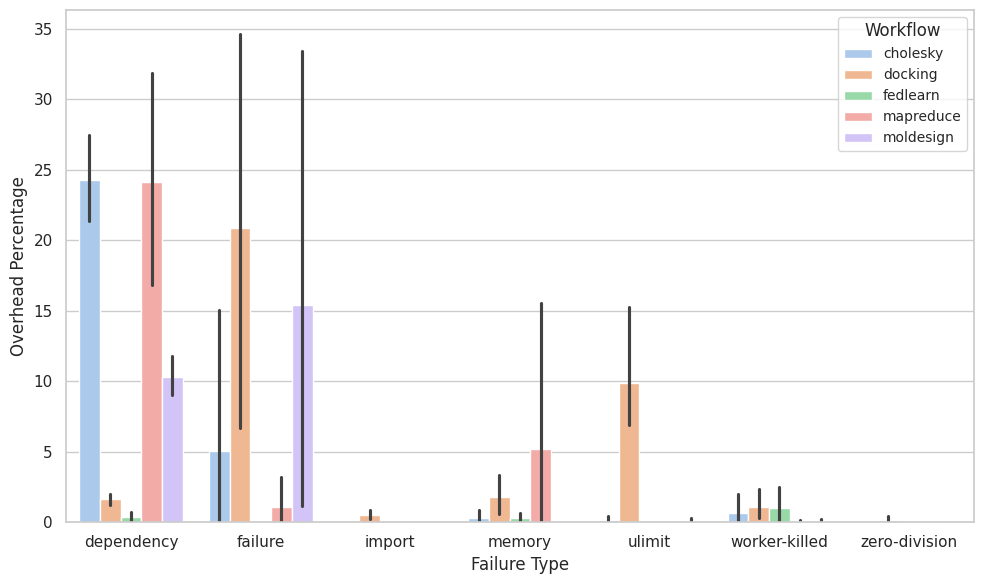

In [15]:
df = df.sort_values(by=['failure_type', 'workflow'])

# 设置绘图风格
sns.set(style="whitegrid")

# 创建分组柱状图
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='failure_type', y='percentage', hue='workflow', data=df, palette='pastel')

# 添加标题和标签
# plt.title('Overhead by Failure Type and Workflow', fontsize=16)
plt.xlabel('Failure Type', fontsize=12)
plt.ylabel('Overhead Percentage', fontsize=12)

# 显示图例
plt.legend(title='Workflow', title_fontsize='12', fontsize='10')

# 调整布局并显示图表
plt.tight_layout()
plt.show()

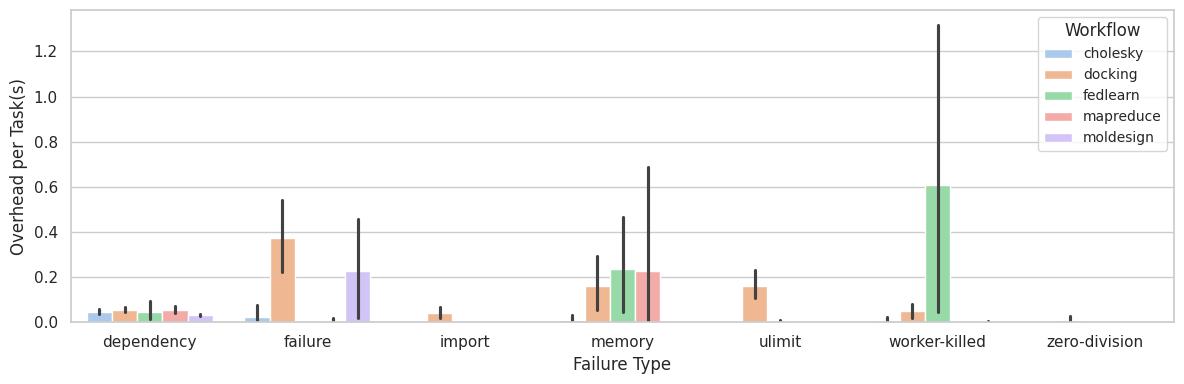

In [16]:
df = df.sort_values(by=['failure_type', 'workflow'])

# 设置绘图风格
sns.set(style="whitegrid")

# 创建分组柱状图
plt.figure(figsize=(12, 4))
ax = sns.barplot(x='failure_type', y='overhead_per_task', hue='workflow', data=df, palette='pastel')

# 添加标题和标签
# plt.title('Overhead per Task by Failure Type and Workflow', fontsize=16)
plt.xlabel('Failure Type', fontsize=12)
plt.ylabel('Overhead per Task(s)', fontsize=12)

# 显示图例
plt.legend(title='Workflow', title_fontsize='12', fontsize='10')

# 调整布局并显示图表
plt.tight_layout()
plt.savefig('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/overhead_per_task.pdf')
plt.show()